<font color='tomato'><font color="#CC3D3D"><p>
# How to Build Neural Networks using Keras
https://www.tensorflow.org/tutorials?hl=ko    

In [5]:
import pandas as pd
import numpy as np
import os
import random
import pickle
from IPython.display import Image
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.1.2


### Import modules

In [6]:
# basic 

import pandas as pd
import numpy as np
import datetime, time
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)


# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

In [7]:
%%writefile word2vec.py

### Imports
import pandas as pd
import numpy as np
import os


### Read data
train = pd.read_csv(os.path.abspath("../dat")+'/train_transactions.csv', encoding='cp949')
test = pd.read_csv("../dat")+'/test_transactions.csv', encoding='cp949')

### Make corpus
p_level = 'gds_grp_nm'  # 상품 분류 수준

# W2V 학습데이터가 부족하여 구매한 상품 목록으로부터 n배 oversampling을 수행
def oversample(x, n, seed=0):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    return list(bs)

train_corpus = list(train.groupby('cust_id')[p_level].agg(oversample, 20))
test_corpus = list(test.groupby('cust_id')[p_level].agg(oversample, 20))


### Training the Word2Vec model
num_features = 100 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 5 # 학습 윈도우(인접한 단어 리스트) 크기

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
w2v = word2vec.Word2Vec(train_corpus, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=0, workers=1)
# 필요없는 메모리 unload
w2v.init_sims(replace=True)


### Make features
# 구매상품에 해당하는 벡터의 평균/최소/최대 벡터를 feature로 만드는 전처리기
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),                
                np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ]) 

# W2V 기반 feature 생성
train_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).fit(train_corpus).transform(train_corpus))
test_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).transform(test_corpus))

train_features.columns = ['v'+f'{c+1:03d}' for c in train_features.columns]
test_features.columns = ['v'+f'{c+1:03d}' for c in test_features.columns]

# 학습용과 제출용 데이터로 분리
pd.concat([pd.DataFrame({'cust_id': np.sort(train['cust_id'].unique())}), train_features], axis=1).to_csv(os.path.abspath("../dat")+'/X_train_w2v.csv', index=False)
pd.concat([pd.DataFrame({'cust_id': np.sort(test['cust_id'].unique())}), test_features], axis=1).to_csv(os.path.abspath("../dat")+'/X_test_w2v.csv', index=False)

Overwriting word2vec.py


In [8]:
import os
import subprocess

subprocess.run(['python', 'word2vec.py'], env={**os.environ, 'PYTHONHASHSEED': '123'})

CompletedProcess(args=['python', 'word2vec.py'], returncode=1)

In [9]:
X_train = pd.read_csv(os.path.abspath("../dat")+'/X_train_w2v.csv', encoding='cp949')
X_test = pd.read_csv(os.path.abspath("../dat")+'/X_test_w2v.csv', encoding='cp949')
train_id = X_train['cust_id']
test_id = X_test['cust_id']
tr_w2v = pd.concat([X_train, X_test])

In [10]:
features_all = pd.DataFrame({'cust_id': tr_w2v.cust_id})
tr_w2v.drop(['cust_id'], axis=1, inplace=True)

In [11]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [12]:
cnt = 0
tr1 = tr_w2v
while True:
    features = tr1.columns[cnt]
    n = tr1.shape[1]
    for x in range(cnt+1, n):
        features += '+' + tr1.columns[x]

    strr = features[:4]
    features = features[5:]
    
    y, X = dmatrices(strr + '~' + features, data = tr1, return_type = "dataframe")
    result = pd.DataFrame(sm.OLS(y, X).fit().pvalues)
    
    idx = result[result[0] > 0.5].index[1:]
    tr1.drop(idx, axis=1, inplace=True)
    
    if n == tr1.shape[1]:
        break
    
    cnt += 1

In [13]:
features_all = pd.concat([features_all, tr1], axis=1)

In [15]:
train = pd.read_csv(os.path.abspath("../dat")+'/train_transactions.csv', encoding='cp949')
test = pd.read_csv(os.path.abspath("../dat")+'/test_transactions.csv', encoding='cp949')


# 전처리를 동일하게 적용하기 위해 두 데이터를 합한다.
tr_bow = pd.concat([train, test])

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv(os.path.abspath("../dat")+'/y_train.csv', encoding='cp949').gender

In [16]:
y_train.shape

(3500,)

In [17]:
level = 'gds_grp_nm'

features1 = pd.pivot_table(tr_bow, index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()
features1

gds_grp_nm,cust_id,14K,4대 B/D,"IT 게임기,S/W",KKD,L.B,L/C 아동복,L/C골프의류,L/C정장,MP3 外,N.B,N.B정장,N/B 아동복,N/B골프의류,NB 남화,NB 여화,TAKE OUT,takeout양과,가 방,가공선물세트,가공행사,가구 단독매입,가방,가스기기,갈비세트,...,트래디셔널Ⅱ,트랜디,트랜디캐주얼,특수야채,패밀리레스토랑,패션 단독매입,패션내의,편집매장,포숑,프레스티지,피아노/악기,피혁,필기류,한과,한과(세트행사),한실침구,한차,햄,햄세트,향수,헤어ACC,홈웨어,화장품,회,휴지류
0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,0,1,0,0,0,0,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5978,5978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5979,5979,0,0,0,0,0,0,1,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5980,5980,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
custid = features1['cust_id']

In [19]:
features1.drop(['cust_id'], axis=1, inplace=True)

In [20]:
idx = []

for x in range(1, 10):
    idx.append('w00' + str(x))
for x in range(10, 100):
    idx.append('w0' + str(x))
for x in range(100, 332):
    idx.append('w' + str(x))

features1.columns = idx

In [21]:
cnt = 0
tr3 = features1
while True:
    features = tr3.columns[cnt]
    n = tr3.shape[1]
    for x in range(cnt+1, n):
        features += '+' + tr3.columns[x]

    strr = features[:4]
    features = features[5:]
    
    y, X = dmatrices(strr + '~' + features, data = tr3, return_type = "dataframe")
    result = pd.DataFrame(sm.OLS(y, X).fit().pvalues)
    
    idx = result[result[0] > 0.5].index[1:]
    tr3.drop(idx, axis=1, inplace=True)
    
    if n == tr3.shape[1]:
        break
    
    cnt += 1

In [22]:
features_all = features_all.merge(pd.concat([custid, tr3], axis=1), how='left', on='cust_id'); 
features_all

,cust_id,v001,v002,v003,v005,v007,v009,v011,v016,v017,v026,v028,v030,v032,v033,v035,v036,v044,v047,v052,v064,v081,v087,v093,v097,...,v223,v227,v244,v245,v255,v258,v268,v277,v289,v291,v368,w001,w002,w006,w007,w010,w011,w015,w019,w024,w039,w071,w088,w286,w328
0,0,0.162036,0.164751,0.185164,0.143619,0.161112,0.173679,0.231939,0.094198,0.245542,0.155513,0.158335,0.209109,0.153925,0.249382,0.141757,0.114139,0.177094,0.158328,0.217829,0.276362,0.155318,0.252479,0.219338,0.309473,...,0.102649,0.074065,-0.031248,-0.048799,-0.059474,0.021273,-0.081145,-0.031783,0.037459,-0.026352,6.680103e-02,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,0.043534,-0.116219,0.030513,0.009706,0.076996,0.132088,0.181402,0.058393,0.149604,0.016534,0.014634,-0.029546,0.198830,0.286137,0.171857,-0.009147,0.171745,0.106817,-0.001929,-0.080138,-0.113799,0.048202,0.124332,-0.024377,...,0.025380,-0.094352,0.157808,-0.050610,-0.054782,0.026866,-0.168408,-0.127895,0.017015,-0.012650,8.065280e-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0.008556,0.098141,-0.010892,0.043367,0.042003,0.191302,0.041089,-0.012370,0.245424,-0.013964,0.049761,-0.006900,0.049132,0.035127,0.070849,-0.026882,0.051724,0.191713,0.100278,0.152993,-0.057108,0.110669,0.219338,0.309473,...,0.213254,0.059194,-0.016683,-0.047516,-0.134672,-0.026746,-0.172384,-0.069225,-0.007058,-0.043955,6.289027e-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0.087708,0.154000,0.153849,0.122535,0.161112,0.282564,0.141564,0.171921,0.132664,0.155513,0.188242,0.215229,0.152471,0.150081,0.142496,0.116336,0.122412,0.082938,0.188491,0.271577,0.154874,0.252479,0.219338,0.309473,...,0.103826,0.063324,-0.070810,-0.069065,-0.015877,0.016030,-0.051110,-0.027775,0.041120,-0.076419,6.166264e-02,0,0,1,0,0,0,0,0,0,0,1,1,0,0
4,4,-0.002521,0.098141,-0.024649,0.043367,0.024817,0.173679,0.077720,-0.004619,0.111000,0.044929,0.146450,-0.119144,-0.041291,0.007028,0.186854,0.120704,-0.037739,0.065476,0.100278,0.152993,0.061838,0.110669,0.219338,0.309473,...,0.139399,0.135030,-0.053790,-0.110803,-0.214659,-0.100898,-0.098353,0.003612,-0.054742,-0.000514,5.498454e-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,0.039225,0.098141,0.059655,0.162299,0.171035,0.173679,0.153070,0.117659,0.229073,-0.013964,0.152103,0.045529,0.094267,0.131673,0.099174,0.027555,0.207279,0.160064,0.119543,0.241255,0.018926,0.110669,0.219338,0.309473,...,0.025548,0.034259,0.015707,-0.035071,-0.099863,0.039019,-0.114949,0.003799,0.023349,-0.012494,3.904816e-02,0,1,0,6,0,0,0,0,0,0,0,0,0,0
5978,5978,0.037781,-0.017197,0.058971,-0.085148,-0.095281,-0.050841,-0.160301,-0.121408,0.071972,0.007905,-0.057411,0.084949,-0.021232,-0.024593,0.046856,-0.103393,0.090005,-0.017078,0.217829,0.121465,-0.040822,-0.071184,0.028791,-0.111856,...,0.078462,0.096269,0.090005,0.019038,-0.070785,0.176329,-0.153840,-0.016029,0.014861,-0.031087,2.980232e-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5979,5979,0.202258,0.161566,0.099089,0.195651,0.225999,0.192774,0.324084,0.137109,0.245424,0.149537,0.146450,0.155650,0.198830,0.286137,0.186854,0.120704,0.171745,0.191713,0.217829,0.183081,0.276366,0.252479,0.219338,0.309473,...,0.016699,0.010902,0.027856,-0.015704,-0.053145,0.013289,-0.071473,-0.012847,-0.020719,-0.023371,1.097105e-01,0,0,0,1,1,0,3,0,0,0,0,0,2,0
5980,5980,0.087708,0.061620,0.050070,0.170499,0.161112,0.066992,0.150776,0.166685,0.132664,0.084607,0.119999,0.155650,0.103712,0.075012,0.010326,0.086018,0.097453,0.029482,0.127383,0.120615,0.140911,0.147350,0.137313,0.164796,...,0.102028,0.073956,-0.103660,-0.039352,-0.085337,0.001117,0.002724,-0.011301,-0.001592,-0.086243,3.907659e-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [23]:
X_train_after_corr = pd.read_csv(os.path.abspath("../dat")+'/X_train_after_corr.csv', encoding='cp949')
X_test_after_corr = pd.read_csv(os.path.abspath("../dat")+'/X_test_after_corr.csv', encoding='cp949')

In [24]:
tr4 = pd.concat([X_train_after_corr,X_test_after_corr])

In [25]:
features_all = features_all.merge(tr4, how='left', on='cust_id'); 
features_all

,cust_id,v001,v002,v003,v005,v007,v009,v011,v016,v017,v026,v028,v030,v032,v033,v035,v036,v044,v047,v052,v064,v081,v087,v093,v097,...,91_w_ten_isbuy,92_w_ten_isbuy,93_w_ten_isbuy,94_w_ten_isbuy,95_w_ten_isbuy,96_w_ten_isbuy,97_w_ten_isbuy,98_w_ten_isbuy,99_w_ten_isbuy,100_w_ten_isbuy,101_w_ten_isbuy,102_w_ten_isbuy,103_w_ten_isbuy,104_w_ten_isbuy,105_w_ten_isbuy,106_w_ten_isbuy,107_w_ten_isbuy,108_w_ten_isbuy,109_w_ten_isbuy,110_w_ten_isbuy,111_w_ten_isbuy,112_w_ten_isbuy,113_w_ten_isbuy,115_w_ten_isbuy,116_w_ten_isbuy
0,0,0.162036,0.164751,0.185164,0.143619,0.161112,0.173679,0.231939,0.094198,0.245542,0.155513,0.158335,0.209109,0.153925,0.249382,0.141757,0.114139,0.177094,0.158328,0.217829,0.276362,0.155318,0.252479,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.043534,-0.116219,0.030513,0.009706,0.076996,0.132088,0.181402,0.058393,0.149604,0.016534,0.014634,-0.029546,0.198830,0.286137,0.171857,-0.009147,0.171745,0.106817,-0.001929,-0.080138,-0.113799,0.048202,0.124332,-0.024377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.008556,0.098141,-0.010892,0.043367,0.042003,0.191302,0.041089,-0.012370,0.245424,-0.013964,0.049761,-0.006900,0.049132,0.035127,0.070849,-0.026882,0.051724,0.191713,0.100278,0.152993,-0.057108,0.110669,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.087708,0.154000,0.153849,0.122535,0.161112,0.282564,0.141564,0.171921,0.132664,0.155513,0.188242,0.215229,0.152471,0.150081,0.142496,0.116336,0.122412,0.082938,0.188491,0.271577,0.154874,0.252479,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,-0.002521,0.098141,-0.024649,0.043367,0.024817,0.173679,0.077720,-0.004619,0.111000,0.044929,0.146450,-0.119144,-0.041291,0.007028,0.186854,0.120704,-0.037739,0.065476,0.100278,0.152993,0.061838,0.110669,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,0.039225,0.098141,0.059655,0.162299,0.171035,0.173679,0.153070,0.117659,0.229073,-0.013964,0.152103,0.045529,0.094267,0.131673,0.099174,0.027555,0.207279,0.160064,0.119543,0.241255,0.018926,0.110669,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5978,5978,0.037781,-0.017197,0.058971,-0.085148,-0.095281,-0.050841,-0.160301,-0.121408,0.071972,0.007905,-0.057411,0.084949,-0.021232,-0.024593,0.046856,-0.103393,0.090005,-0.017078,0.217829,0.121465,-0.040822,-0.071184,0.028791,-0.111856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5979,5979,0.202258,0.161566,0.099089,0.195651,0.225999,0.192774,0.324084,0.137109,0.245424,0.149537,0.146450,0.155650,0.198830,0.286137,0.186854,0.120704,0.171745,0.191713,0.217829,0.183081,0.276366,0.252479,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5980,5980,0.087708,0.061620,0.050070,0.170499,0.161112,0.066992,0.150776,0.166685,0.132664,0.084607,0.119999,0.155650,0.103712,0.075012,0.010326,0.086018,0.097453,0.029482,0.127383,0.120615,0.140911,0.147350,0.137313,0.164796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
X_train = pd.read_csv(os.path.abspath("../dat")+'/X_train.csv', encoding='cp949')
X_test = pd.read_csv(os.path.abspath("../dat")+'/X_test.csv', encoding='cp949')

In [28]:
tr5 = pd.concat([X_train,X_test])

In [29]:
features_all = features_all.merge(tr4, how='left', on='cust_id'); 
features_all

,cust_id,v001,v002,v003,v005,v007,v009,v011,v016,v017,v026,v028,v030,v032,v033,v035,v036,v044,v047,v052,v064,v081,v087,v093,v097,...,91_w_ten_isbuy_y,92_w_ten_isbuy_y,93_w_ten_isbuy_y,94_w_ten_isbuy_y,95_w_ten_isbuy_y,96_w_ten_isbuy_y,97_w_ten_isbuy_y,98_w_ten_isbuy_y,99_w_ten_isbuy_y,100_w_ten_isbuy_y,101_w_ten_isbuy_y,102_w_ten_isbuy_y,103_w_ten_isbuy_y,104_w_ten_isbuy_y,105_w_ten_isbuy_y,106_w_ten_isbuy_y,107_w_ten_isbuy_y,108_w_ten_isbuy_y,109_w_ten_isbuy_y,110_w_ten_isbuy_y,111_w_ten_isbuy_y,112_w_ten_isbuy_y,113_w_ten_isbuy_y,115_w_ten_isbuy_y,116_w_ten_isbuy_y
0,0,0.162036,0.164751,0.185164,0.143619,0.161112,0.173679,0.231939,0.094198,0.245542,0.155513,0.158335,0.209109,0.153925,0.249382,0.141757,0.114139,0.177094,0.158328,0.217829,0.276362,0.155318,0.252479,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.043534,-0.116219,0.030513,0.009706,0.076996,0.132088,0.181402,0.058393,0.149604,0.016534,0.014634,-0.029546,0.198830,0.286137,0.171857,-0.009147,0.171745,0.106817,-0.001929,-0.080138,-0.113799,0.048202,0.124332,-0.024377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.008556,0.098141,-0.010892,0.043367,0.042003,0.191302,0.041089,-0.012370,0.245424,-0.013964,0.049761,-0.006900,0.049132,0.035127,0.070849,-0.026882,0.051724,0.191713,0.100278,0.152993,-0.057108,0.110669,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.087708,0.154000,0.153849,0.122535,0.161112,0.282564,0.141564,0.171921,0.132664,0.155513,0.188242,0.215229,0.152471,0.150081,0.142496,0.116336,0.122412,0.082938,0.188491,0.271577,0.154874,0.252479,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,-0.002521,0.098141,-0.024649,0.043367,0.024817,0.173679,0.077720,-0.004619,0.111000,0.044929,0.146450,-0.119144,-0.041291,0.007028,0.186854,0.120704,-0.037739,0.065476,0.100278,0.152993,0.061838,0.110669,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,0.039225,0.098141,0.059655,0.162299,0.171035,0.173679,0.153070,0.117659,0.229073,-0.013964,0.152103,0.045529,0.094267,0.131673,0.099174,0.027555,0.207279,0.160064,0.119543,0.241255,0.018926,0.110669,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5978,5978,0.037781,-0.017197,0.058971,-0.085148,-0.095281,-0.050841,-0.160301,-0.121408,0.071972,0.007905,-0.057411,0.084949,-0.021232,-0.024593,0.046856,-0.103393,0.090005,-0.017078,0.217829,0.121465,-0.040822,-0.071184,0.028791,-0.111856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5979,5979,0.202258,0.161566,0.099089,0.195651,0.225999,0.192774,0.324084,0.137109,0.245424,0.149537,0.146450,0.155650,0.198830,0.286137,0.186854,0.120704,0.171745,0.191713,0.217829,0.183081,0.276366,0.252479,0.219338,0.309473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5980,5980,0.087708,0.061620,0.050070,0.170499,0.161112,0.066992,0.150776,0.166685,0.132664,0.084607,0.119999,0.155650,0.103712,0.075012,0.010326,0.086018,0.097453,0.029482,0.127383,0.120615,0.140911,0.147350,0.137313,0.164796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LogisticRegression
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler

In [31]:
features_all.iloc[:,1:] = features_all.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

In [32]:
features_all.iloc[:,1:] = np.log1p(features_all.iloc[:,1:])

In [33]:
x_train = features_all[:3500]
x_test = features_all[3500:]

scaler = MinMaxScaler()

x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

train_test = pd.concat([x_train, x_test], ignore_index=True)

In [34]:
x_train.shape, x_test.shape, y_train.shape

((3500, 2861), (2482, 2861), (3500,))

In [35]:
max_col = train_test.shape[1]
pca = PCA(n_components=max_col, random_state=0).fit(train_test)

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_col = np.argmax(cumsum >= 0.99) + 1

# num_col 이 1이었기 때문에 num_col은 max_col이 되었다

if num_col == 1:
    num_col = max_col

pca = PCA(n_components = num_col, random_state=0).fit_transform(train_test)
train_test = pd.DataFrame(pca)

In [36]:
train_test = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), train_test], axis=1)
X_train = train_test.query('cust_id in @train_id').drop('cust_id', axis=1)
X_test = train_test.query('cust_id in @test_id').drop('cust_id', axis=1)
X_test = train_test.query('cust_id in @test_id')

In [37]:
X_train.shape, X_test.shape

((3500, 230), (2482, 231))

In [38]:
X_train, X_test1, y_train, y_test1 = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [39]:
X_train.shape, X_test1.shape, y_train.shape, y_test1.shape

((2450, 230), (1050, 230), (2450,), (1050,))

In [40]:
X_test.shape

(2482, 231)

In [41]:
ID_dep = X_test[['cust_id']]  
#ID_dep = X_test["cust_id"].str.split(" ", n = 1, expand = True)

In [42]:
ID_dep = np.arange(3500, 5982, 1)

In [43]:
X_test = X_test.drop('cust_id', axis=1)

### Set random seeds to make your results reproducible

In [44]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1234)
    random.seed(1234)
    tf.compat.v1.set_random_seed(1234)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


##### Feature scaling

In [45]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

##### Split data into train & validation set 

In [46]:
# Train/Validation
i = int(round(X_train.shape[0] * 0.8,0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

### Step 2: Define the model architecture

##### Stack layers from input to output

|모듈|사용 예 및 종류|
|---|:---:|
|Initializer| Dense(16, kernel_initializer='he_normal')|
|Regularizer| Dense(16, kernel_regularizer=l2(0.01))|
|Activation|relu / elu / selu / softmax / tanh / sigmoid / linear|

In [47]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))
def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [48]:
# Input => Dense + Dense + ... => output
# Model(input, output)

input = keras.Input(shape=(X_train.shape[1],))

In [49]:
x = keras.layers.Dense(64, activation='sigmoid', kernel_initializer = my_glorot_initializer,
                      kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights)(input)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(32, activation='sigmoid')(input)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(16, activation='sigmoid')(x)
x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(8, activation='sigmoid')(x)
# x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x) 
model = keras.Model(input, output)

##### Notes
kernel_regularizer='l2' doesn't make a difference in x = keras.layers.Dense(64, activation='sigmoid')(input)

*Keras Sequential API*
```
model = Sequential([
  keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
  keras.layers.Dense(8),
  keras.layers.Dense(1, activation='sigmoid')
])
```

##### Summarize & visualize the model

In [50]:
model.summary()
#Image(keras.utils.model_to_dot(model,show_shapes=True,show_layer_names=False, dpi=100) \
#     .create(prog='dot', format='png'))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 230)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                7392      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 7,937
Trainable params: 7,937
Non-trainable params: 0
___________________________________________________________

### Step 3: Choose the optimizer and the cost function
<img align='left' src='http://drive.google.com/uc?export=view&id=1xybqHMvcDDfUYSN3FLQ6Y1708QkiZSJt' style="width: 70%">

*Optimizer의 예:*
- keras.optimizers.SGD(lr=0.01, momentum=0.9)
- keras.optimizers.RMSprop(lr=0.001, rho=0.9)
- keras.optimizers.Adagrad(lr=0.01)
- keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [51]:
# loss, optimizer, metrics 설정
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc', keras.metrics.AUC()])

### Step 4: Train the model

##### Set learning conditions & fit the model 

In [52]:
# batch size, epoch, 조기종료조건 등 설정
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),]
# keras.callbacks.ModelCheckpoint(filepath='best_nn_model.h5', monitor='val_loss', save_best_only=True)]

hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                 batch_size=64, epochs=300, callbacks=callbacks, shuffle=False, verbose=2)

Train on 1960 samples, validate on 490 samples
Epoch 1/300
1960/1960 - 1s - loss: 0.7240 - acc: 0.5852 - auc: 0.5159 - val_loss: 0.6582 - val_acc: 0.6245 - val_auc: 0.6058
Epoch 2/300
1960/1960 - 0s - loss: 0.7075 - acc: 0.5806 - auc: 0.5198 - val_loss: 0.6531 - val_acc: 0.6245 - val_auc: 0.6647
Epoch 3/300
1960/1960 - 0s - loss: 0.6950 - acc: 0.5816 - auc: 0.5232 - val_loss: 0.6494 - val_acc: 0.6245 - val_auc: 0.6938
Epoch 4/300
1960/1960 - 0s - loss: 0.6842 - acc: 0.5765 - auc: 0.5370 - val_loss: 0.6462 - val_acc: 0.6245 - val_auc: 0.7115
Epoch 5/300
1960/1960 - 0s - loss: 0.6833 - acc: 0.5862 - auc: 0.5336 - val_loss: 0.6431 - val_acc: 0.6245 - val_auc: 0.7182
Epoch 6/300
1960/1960 - 0s - loss: 0.6662 - acc: 0.6102 - auc: 0.5692 - val_loss: 0.6400 - val_acc: 0.6245 - val_auc: 0.7277
Epoch 7/300
1960/1960 - 0s - loss: 0.6666 - acc: 0.5867 - auc: 0.5615 - val_loss: 0.6369 - val_acc: 0.6245 - val_auc: 0.7300
Epoch 8/300
1960/1960 - 0s - loss: 0.6617 - acc: 0.6117 - auc: 0.5717 - val_lo

##### Visualize training history 

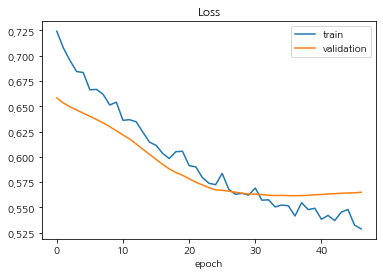

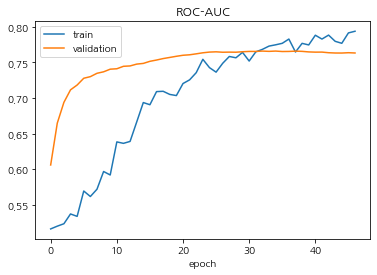

In [53]:
# Loss
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("Loss")
plt.show()

# ROC-AUC
plt.plot(hist.history["auc"], label="train")
plt.plot(hist.history["val_auc"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("ROC-AUC")
plt.show()

### Step 5: Evaluate the model performance

In [54]:
# Loss, Accuracy & ROC-AUC
#model.evaluate(X_test, y_test)
model.evaluate(X_test1, y_test1)

1050/1050 [==============================] - 0s 61us/sample - loss: 0.5785 - acc: 0.6990 - auc: 0.7429


[0.5784733938603174, 0.6990476, 0.7429197]

### Step 6: Predict unseen data

In [55]:
# Generates output predictions for the input samples
model.predict(X_test).flatten()

array([0.7164613 , 0.30119205, 0.20951754, ..., 0.5987664 , 0.36667094,
       0.58379996], dtype=float32)

In [56]:
# Get class labels
np.where(model.predict(X_test) > 0.5, 1, 0).flatten()

array([1, 0, 0, ..., 1, 0, 1])

In [57]:
#'cust_id': ID_dep,

In [52]:
# Make submissions: (결과) 0.762053
t = pd.Timestamp.now()
fname = f"dnn_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
pd.DataFrame({'cust_id': ID_dep, 'gender': model.predict(X_test).flatten()}).to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'dnn_submission_12101621.csv' is ready to submit.


###  Step 7: Save the model for future use

In [ ]:
# pickle 형식으로 저장
# with open('nn_model.pkl', 'wb') as f:
#    pickle.dump(model, f)

# 추후 저장한 모형 불러올 때: 
# model = pd.read_pickle('nn_model.pkl')

In [ ]:
# h5 형식으로 저장
# model.save('nn_model.h5')

# 추후 저장한 모형 불러올 때: 
# model = load_model('nn_model.h5')

<font color="#CC3D3D"><p>
# End